![Banner](img/AI_Special_Program_Banner.jpg)

## Hyperparameter Optimization (HPO) w/ Optuna - Workshop - Solution Part 2
---

***Data Source**: [Kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)*

***Optuna Documentation**: [https://optuna.readthedocs.io/en/stable/](https://optuna.readthedocs.io/en/stable/)*

# Hyperparameter Optimization (HPO) w/ Optuna - Neural Architecture Search
---

Optuna features a very powerful **define-by-run** principle which does not limit the user to a static model definition. Instead, it is possible to freely define the search space while the optimization is already being performed. This allows for adaptations to the model design (number of layers, neurons, etc.) - which could be considered a special set of hyperparameters. Because this kind of optimization deals with the network architecture itself, the process is specifically called **neural architecture search**. This notebook implements such a NAS on a very basic level.

> **Library imports and general settings**:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch
import torch.nn as nn

###
import optuna
import torch.optim as optim
###

In [2]:
EPOCHS = 50
CLASSES = 3

torch.manual_seed(42)
random.seed(42)
RANDOM_SEED = 42

> **Definition of (selected) hyperparameters**:

> **Data preparation**:

In [3]:
data = pd.read_csv('data/HPO_Data.csv')
data.head()

,baseline_value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [4]:
len(data)

2126

In [5]:
data.isnull().any().any()

False

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

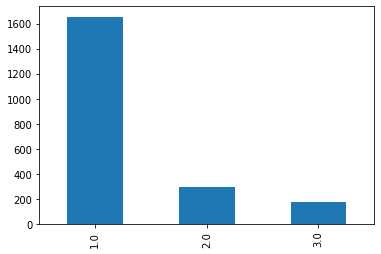

In [6]:
data.fetal_health.value_counts().plot(kind='bar')
data.fetal_health.value_counts()

In [7]:
null_accuracy = data.fetal_health.value_counts()[1.0]/len(data)
null_accuracy

0.7784571966133584

In [8]:
encoder = OrdinalEncoder()
oe_columns = ['fetal_health']
encoder.fit(data[oe_columns])
data[oe_columns] = encoder.transform(data[oe_columns])

In [9]:
data.fetal_health.value_counts()

0.0    1655
1.0     295
2.0     176
Name: fetal_health, dtype: int64

> **Creating helper classes and methods**:

In [10]:
class FetalHealthData(torch.utils.data.Dataset):
    def __init__(self, data):
        self.labels = data.fetal_health.tolist()
        self.features = data.drop(columns=['fetal_health'], axis=1).values.tolist()
    
    def __getitem__(self, index):
        sample = np.array(self.features[index]), np.array(self.labels[index])
        return sample
        
    def __len__(self):
        return len(self.labels)

In [11]:
def get_model(params, trial):
    # Suggesting Numbers of Hidden Layers
    num_layers = trial.suggest_int('num_layers', 2, 4)
    
    layers = list()
    
    # 21 Input Features
    in_features = len(data.drop(columns=['fetal_health'], axis=1).columns)
    
    # Suggest Numbers of Neurons for each Hidden Layer
    for layer in range(num_layers):
        out_features = trial.suggest_int(f'layer_{layer}', 8, 256)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU())
        
        in_features = out_features
    
    layers.append(nn.Dropout())
    layers.append(nn.Linear(in_features, CLASSES))

    return nn.Sequential(*layers)

In [12]:
# HP: Batch Size
def get_data(params):
    
    ###
    batch_size = params['batch_size']
    ###
    
    training_data, testing_data = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data.fetal_health)
    training_data, testing_data = FetalHealthData(training_data), FetalHealthData(testing_data)
    return torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True), torch.utils.data.DataLoader(testing_data, batch_size=batch_size, shuffle=False)

In [13]:
# HP: Optimizer, Learning Rate, Weight Decay
def get_optimizer(model, params):
    
    ###
    optimizer = params['optimizer']
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    ###
    
    if optimizer == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # return getattr(optim, optimizer)(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

> **Creating training loop**:

In [14]:
# HP: Scheduler
def train(model, training_batches, testing_batches, params):
    ###
    scheduler = params['scheduler']
    ###
    
    accuracy = list()
    criterion = nn.CrossEntropyLoss()
    
    ###
    optimizer = get_optimizer(model, params)
    ###
    
    if scheduler:
        scheduler = CosineAnnealingLR(optimizer, EPOCHS-1, verbose=False)
    
    for epoch in range(EPOCHS):
        ### Training
        model.train()
        for samples, labels in training_batches:
            optimizer.zero_grad()
            outputs = model(samples.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        
        num_samples = 0
        correct_predictions = 0
        ### Testing
        model.eval()
        with torch.no_grad():
            for samples, labels in testing_batches:
                output = model(samples.float())
                correct_predictions += (output.argmax(dim=1) == labels).sum().item()
                num_samples += labels.size(0)
            
        accuracy.append(100.0 * correct_predictions / num_samples)
    
    return accuracy

> **Creating a study object (in memory)**:

In [15]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))

[I 2022-10-30 14:36:38,406] A new study created in memory with name: no-name-1499f593-0365-4b3f-b5f4-9dd43407e3b8


> **Defining an objective function**:

In [16]:
def objective(trial):
    params = {
        'batch_size': trial.suggest_int('batch_size', 8, 128),
        'optimizer': trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-5, 1e-1),
        'scheduler': True if trial.suggest_int('scheduler', 0, 1) == 1 else False
    }
    
    ###
    model = get_model(params, trial)
    ###
    
    training_batches, testing_batches = get_data(params)
    history = train(model, training_batches, testing_batches, params)
    
    # Fitness-Value
    return history[-1]

> **Optimizing parameters**:

In [17]:
study.optimize(objective, n_trials=10)

[I 2022-10-30 14:36:41,066] Trial 0 finished with value: 77.93427230046949 and parameters: {'batch_size': 53, 'optimizer': 'SGD', 'learning_rate': 4.207988669606632e-05, 'weight_decay': 4.207053950287933e-05, 'scheduler': 0, 'num_layers': 4, 'layer_0': 157, 'layer_1': 184, 'layer_2': 13, 'layer_3': 249}. Best is trial 0 with value: 77.93427230046949.
[I 2022-10-30 14:36:42,254] Trial 1 finished with value: 84.03755868544602 and parameters: {'batch_size': 108, 'optimizer': 'SGD', 'learning_rate': 0.00016480446427978953, 'weight_decay': 0.0012561043700013551, 'scheduler': 0, 'num_layers': 2, 'layer_0': 160, 'layer_1': 42}. Best is trial 1 with value: 84.03755868544602.
[I 2022-10-30 14:36:49,447] Trial 2 finished with value: 85.21126760563381 and parameters: {'batch_size': 43, 'optimizer': 'RMSprop', 'learning_rate': 6.290644294586152e-05, 'weight_decay': 0.0011400863701127321, 'scheduler': 1, 'num_layers': 2, 'layer_0': 159, 'layer_1': 50}. Best is trial 2 with value: 85.21126760563381.

In [18]:
study.best_params

{'batch_size': 119,
 'optimizer': 'Adam',
 'learning_rate': 0.0002001342062287998,
 'weight_decay': 0.00035868164986275477,
 'scheduler': 0,
 'num_layers': 4,
 'layer_0': 96,
 'layer_1': 77,
 'layer_2': 143,
 'layer_3': 43}

In [19]:
study.optimize(objective, n_trials=5)

[I 2022-10-30 14:37:29,102] Trial 10 finished with value: 84.03755868544602 and parameters: {'batch_size': 126, 'optimizer': 'Adam', 'learning_rate': 0.07553503645583222, 'weight_decay': 0.030337134645398185, 'scheduler': 0, 'num_layers': 3, 'layer_0': 97, 'layer_1': 105, 'layer_2': 150}. Best is trial 5 with value: 85.91549295774648.
[I 2022-10-30 14:38:30,280] Trial 11 finished with value: 88.02816901408451 and parameters: {'batch_size': 9, 'optimizer': 'Adam', 'learning_rate': 0.0005751707844202116, 'weight_decay': 7.21137736480159e-05, 'scheduler': 1, 'num_layers': 3, 'layer_0': 87, 'layer_1': 144, 'layer_2': 133}. Best is trial 11 with value: 88.02816901408451.
[I 2022-10-30 14:38:39,666] Trial 12 finished with value: 88.02816901408451 and parameters: {'batch_size': 69, 'optimizer': 'Adam', 'learning_rate': 0.0010240036498641333, 'weight_decay': 9.188227716652768e-05, 'scheduler': 1, 'num_layers': 3, 'layer_0': 94, 'layer_1': 151, 'layer_2': 133}. Best is trial 11 with value: 88.0

In [20]:
study.best_params

{'batch_size': 69,
 'optimizer': 'Adam',
 'learning_rate': 0.004399698345455776,
 'weight_decay': 8.035585398137422e-05,
 'scheduler': 1,
 'num_layers': 3,
 'layer_0': 245,
 'layer_1': 163,
 'layer_2': 91}